In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -V

Python 3.10.12


In [ ]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 31.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292701 sha256=b76a27f05340f109050a75738a5481c7132883d6307d7e72cbf0f0fea78c61b8
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, ht

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-grve4ndy/kobert-tokenizer_9213632182e94c4f88285a4636603a8f
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-grve4ndy/kobert-tokenizer_9213632182e94c4f88285a4636603a8f
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=6eedab16bab29dd34f8fbf149db8883b1930182aead0df7411164f69cf1631b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jegx2tdd/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
class BERTSentenceTransform:

    def __init__(self, tokenizer, max_seq_length, vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab ##추가

    def __call__(self, line):


        # 유니코드로 변환
        text_a = line[0]
        if self._pair:
            assert len(line) == 2  # 2개로 이뤄진문장 있을 수 있음
            text_b = line[1]

        #tokens_a = self._tokenizer(text_a)
        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # `tokens_a` 와 `tokens_b` max_seq_length-3을 넘지 않도록 수정
            # [CLS], [SEP], [SEP]를 포함하므로 "- 3" 들어가야함
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # 문장 한 개일 경우 [CLS], [SEP] 두 개이므로 "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]


        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        #input_ids = tokens_a['input_ids']

        # 문장의 유효길이 valid_length는 input_ids의 길이. 그 이외는 0 패딩
        valid_length = len(input_ids)

        if self._pad:
            # 시퀀스 길이만큼 0 패딩
            padding_length = self._max_seq_length - valid_length
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

#데이터셋 input_ids, valid_length, segment_ids 로
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 num_classes,
                 hidden_size = 768,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 데이터셋 - 7가지 감정

In [ ]:
import pandas as pd
import re

In [ ]:
emotion_dict = {0: 'fear', 1: 'surprise', 2: 'angry', 3: 'sad', 4: 'neutral', 5: 'happiness', 6: 'disgust'}

In [ ]:
chatbot_data1 = pd.read_csv('/content/drive/MyDrive/KOBERT/data/4차년도.csv', encoding="CP949")
chatbot_data2 = pd.read_csv('/content/drive/MyDrive/KOBERT/data/5차년도.csv', encoding="CP949")
chatbot_data3 = pd.read_csv('/content/drive/MyDrive/KOBERT/data/5차년도_2차.csv', encoding="CP949")

df = pd.DataFrame()
df = pd.concat([pd.DataFrame(chatbot_data1['발화문']), pd.DataFrame(chatbot_data2['발화문']), pd.DataFrame(chatbot_data3['발화문'])], ignore_index=True)
df['상황'] = pd.concat([pd.DataFrame(chatbot_data1['상황']), pd.DataFrame(chatbot_data2['상황']), pd.DataFrame(chatbot_data3['상황'])], ignore_index=True)

df.loc[df['상황'] == 'sadness', '상황'] = 'sad'
df.loc[df['상황'] == 'anger', '상황'] = 'angry'

emotion_mapping = {label: key for key, label in emotion_dict.items()}
df['상황'] = df['상황'].map(emotion_mapping)

# 데이터셋을 각각의 리스트형식으로 변환 : input 형식
data_list = [[re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣\s\.]', '', q),
                          str(label)] for q, label in zip(df['발화문'], df['상황'])]

In [ ]:
print(len(data_list), '\n')
data_list[100:115]

43991 



[['자긴 권태긴 것 같다고 시간을 갖자고 그러더라. 그런데 결국 다른 사람이 생긴 것 같아.', '3'],
 ['아니. 술 마시고 계단에서 넘어지셔서 지금 병원에 있어.', '2'],
 ['응. 잠깐 허리만 삐끗하신 것 같아.', '2'],
 ['처음에는 몇 번 했는데 이제는 거의 포기 상태야.', '2'],
 ['사실 두 달도 넘었어.', '3'],
 ['룸메랑 싸우는 것도 이제 지긋지긋하다 정말.', '2'],
 ['당연히 화내봤지 근데 그것도 그때 뿐이야.', '2'],
 ['보증금이 인데 나 혼자서 부담할 수가 없잖아.', '2'],
 ['화장실에 토한 거 그대로 있다.', '6'],
 ['속이 미슥미슥 거려. 나도 토할 거 같애.', '6'],
 ['그래야겠다. 나가는 김에 얘기하고 가야겠어.', '6'],
 ['아니 약속을 해놓고 왜 얘는 이렇게 안 와', '2'],
 ['지금 한 시간이 넘었어', '2'],
 ['위로해줘서. 응 다시 준비해야지.', '3'],
 ['다. 밥 먹었어 방금.', '3']]

In [ ]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=42)

In [ ]:
print(len(dataset_train), '', len(dataset_test))

32993  10998


In [ ]:
dataset_train[0:10]

[['나 축하해줘. 기분 좋은 일 있었어.', '5'],
 ['당연히 말씀 드려야지 다시는 그렇게 행동 못 하게 혼쭐을 내야 해', '6'],
 ['그거 괜찮은데', '2'],
 ['지금 막 퇴근하고 들어왔는데 회사에서 또 전화왔어.', '2'],
 ['어제 우리 아빠가 또 다쳤어.', '2'],
 ['아 짜증 나. 친구가 안 와.', '2'],
 ['전화는 안 할래.', '6'],
 ['프로젝트 하느라고 머리가 너무 아팠는데 이번 기회에 여행을 가서 머리 좀 식히고 와야겠어.', '5'],
 ['지금 친구한테 전화해서 약속 장소를 옮길지 약속을 취소할지 한 번 이야기 나누어봐야겠어. 괜히 만났다가 서로 아프게 되면 더 안 좋잖아.',
  '0'],
 ['다행히 해피는 안 다쳤어.', '1']]

In [ ]:
# Setting parameters
max_len = 64
batch_size = 16
warmup_ratio = 0.1
num_epochs =5
max_grad_norm = 1
log_interval = 200
learning_rate =  (5e-5)

In [ ]:
## test

text_a = ' 나 축하해줘. 기분 좋은 일 있었어 .'
max_seq_length = max_len

tokens = []
tokens_a = tokenizer(text_a)
tokens.append(vocab.cls_token)
tokens.extend(tokens_a)
tokens.append(vocab.sep_token)
segment_ids = [0] * len(tokens)

input_ids = tokenizer.convert_tokens_to_ids(tokens)

valid_length = len(input_ids)

padding_length = max_seq_length - valid_length
input_ids.extend([vocab[vocab.padding_token]] * padding_length)
segment_ids.extend([0] * padding_length)

print('tokens : ', tokens)
print('segment_ids : ', segment_ids)
print('input_ids : ', input_ids)

tokens :  ['[CLS]', 'input_ids', 'token_type_ids', 'attention_mask', '[SEP]']
segment_ids :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_ids :  [2, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'), np.array(segment_ids, dtype='int32')

(array([2, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int32),
 array(5, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32))

In [ ]:
dataset_train_test = [['나 축하해줘. 기분 좋은 일 있었어.', '5'],
 ['당연히 말씀 드려야지! 다시는 그렇게 행동 못 하게 혼쭐을 내야 해!', '6'],
 ['그거 괜찮은데?', '2']]

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [ ]:
type(data_train[0][0])

numpy.ndarray

In [ ]:
len(data_train)

32993

In [ ]:
for i in range(10, 15):
  print(data_train[i])

(array([   2, 4955, 1597, 1754, 2265, 2695, 5861, 4902, 6116, 5018, 1458,
       5213, 6885, 5377, 5928,   54, 3742, 1458, 1365, 6553, 5103, 5330,
       6416, 7848,   54,    3,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32), array(26, dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32), 5)
(array([   2, 2084, 5859, 3135, 7271, 5439, 5007, 4162, 7640, 7807,   54,
          3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
    

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [ ]:
train_dataloader

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5, num_classes=7).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

history = {'train_acc': [], 'train_f1': [], 'train_loss': [], 'test_acc': [], 'test_f1': []}

best_test_f1 = 0.0  # 가장 높은 검증 F1 스코어를 저장할 변수
patience = 3  # early stopping을 위한 기다리는 최대 epoch 수
early_stopping_counter = 0  # early stopping 카운터

for e in range(num_epochs):
    train_acc = 0.0
    train_f1 = 0.0
    train_loss = 0.0
    train_preds = []
    train_labels = []

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        loss = loss_fn(out, label)
        loss.backward()
        train_loss = loss.data.cpu().numpy()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)
        train_preds += out.argmax(dim=-1).tolist()
        train_labels += label.tolist()

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, train_loss, train_acc / (batch_id+1)))

    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    print("epoch {} train acc {} train f1 {}".format(e+1, train_acc / (batch_id+1), train_f1))
    history['train_acc'].append((train_acc / (batch_id+1)))
    history['train_f1'].append(train_f1)
    history['train_loss'].append(train_loss)

    model.eval()
    test_acc = 0.0
    test_f1 = 0.0
    test_preds = []
    test_labels = []

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_acc += calc_accuracy(out, label)
        test_preds += out.argmax(dim=-1).tolist()
        test_labels += label.tolist()

    test_f1 = f1_score(test_labels, test_preds, average='weighted')

    print("epoch {} test acc {} test f1 {}".format(e+1, test_acc / (batch_id+1), test_f1))
    # Save to history
    history['test_acc'].append((test_acc / (batch_id+1)))
    history['test_f1'].append(test_f1)

    if test_f1 > best_test_f1:  # 검증 F1 스코어가 이전보다 높을 경우
        best_test_f1 = test_f1
        early_stopping_counter = 0  # early stopping 카운터 초기화
    else:
        early_stopping_counter += 1  # 검증 F1 스코어가 이전과 같거나 낮을 경우 카운터 증가

    if early_stopping_counter >= patience:  # early stopping 카운터가 patience 값 이상일 경우 학습 종료
        print(f"Early stopping at epoch {e+1}")
        break

  0%|          | 1/1032 [00:00<09:24,  1.83it/s]

epoch 1 batch id 1 loss 1.979154348373413 train acc 0.125


 19%|█▉        | 201/1032 [01:05<04:41,  2.95it/s]

epoch 1 batch id 201 loss 1.4124910831451416 train acc 0.3381529850746269


 39%|███▉      | 401/1032 [02:15<03:42,  2.84it/s]

epoch 1 batch id 401 loss 0.44137120246887207 train acc 0.5267300498753117


 58%|█████▊    | 601/1032 [03:24<02:30,  2.87it/s]

epoch 1 batch id 601 loss 0.43608519434928894 train acc 0.6295757071547421


 78%|███████▊  | 801/1032 [04:34<01:19,  2.89it/s]

epoch 1 batch id 801 loss 0.40650010108947754 train acc 0.6876560549313359


 97%|█████████▋| 1001/1032 [05:44<00:10,  2.87it/s]

epoch 1 batch id 1001 loss 0.3057500123977661 train acc 0.7252747252747253


100%|██████████| 1032/1032 [05:55<00:00,  2.91it/s]


epoch 1 train acc 0.7299236918604651 train f1 0.7273266897098559


100%|██████████| 344/344 [00:41<00:00,  8.22it/s]


epoch 1 test acc 0.8945808007399577 test f1 0.8944539565232467


  0%|          | 1/1032 [00:00<08:00,  2.15it/s]

epoch 2 batch id 1 loss 0.41610485315322876 train acc 0.90625


 19%|█▉        | 201/1032 [01:10<04:52,  2.84it/s]

epoch 2 batch id 201 loss 0.41163724660873413 train acc 0.8804415422885572


 39%|███▉      | 401/1032 [02:19<03:40,  2.87it/s]

epoch 2 batch id 401 loss 0.04954707995057106 train acc 0.890819825436409


 58%|█████▊    | 601/1032 [03:29<02:29,  2.88it/s]

epoch 2 batch id 601 loss 0.21712858974933624 train acc 0.8990744592346089


 78%|███████▊  | 801/1032 [04:39<01:20,  2.87it/s]

epoch 2 batch id 801 loss 0.13844123482704163 train acc 0.9045333957553059


 97%|█████████▋| 1001/1032 [05:48<00:10,  2.86it/s]

epoch 2 batch id 1001 loss 0.18441005051136017 train acc 0.9099338161838162


100%|██████████| 1032/1032 [05:59<00:00,  2.87it/s]


epoch 2 train acc 0.9103682170542635 train f1 0.9101452896600108


100%|██████████| 344/344 [00:41<00:00,  8.23it/s]


epoch 2 test acc 0.9128402484143763 test f1 0.9126685256351826


  0%|          | 1/1032 [00:00<07:51,  2.19it/s]

epoch 3 batch id 1 loss 0.34029334783554077 train acc 0.8125


 19%|█▉        | 201/1032 [01:10<04:48,  2.88it/s]

epoch 3 batch id 201 loss 0.3258080780506134 train acc 0.9287935323383084


 39%|███▉      | 401/1032 [02:20<03:40,  2.86it/s]

epoch 3 batch id 401 loss 0.005452850833535194 train acc 0.935785536159601


 58%|█████▊    | 601/1032 [03:30<02:30,  2.85it/s]

epoch 3 batch id 601 loss 0.26215440034866333 train acc 0.9383839434276207


 78%|███████▊  | 801/1032 [04:40<01:20,  2.85it/s]

epoch 3 batch id 801 loss 0.0825529471039772 train acc 0.9408161672908864


 97%|█████████▋| 1001/1032 [05:49<00:10,  2.87it/s]

epoch 3 batch id 1001 loss 0.07706556469202042 train acc 0.9440871628371629


100%|██████████| 1032/1032 [06:00<00:00,  2.86it/s]


epoch 3 train acc 0.9444040697674418 train f1 0.9443108357851067


100%|██████████| 344/344 [00:41<00:00,  8.22it/s]


epoch 3 test acc 0.9206031976744186 test f1 0.9204647322084027


  0%|          | 1/1032 [00:00<07:59,  2.15it/s]

epoch 4 batch id 1 loss 0.35040074586868286 train acc 0.875


 19%|█▉        | 201/1032 [01:10<04:49,  2.87it/s]

epoch 4 batch id 201 loss 0.2005304992198944 train acc 0.9514925373134329


 39%|███▉      | 401/1032 [02:20<03:39,  2.87it/s]

epoch 4 batch id 401 loss 0.0025865528732538223 train acc 0.9587749376558603


 58%|█████▊    | 601/1032 [03:29<02:29,  2.88it/s]

epoch 4 batch id 601 loss 0.16232356429100037 train acc 0.9612624792013311


 78%|███████▊  | 801/1032 [04:39<01:20,  2.87it/s]

epoch 4 batch id 801 loss 0.05870320275425911 train acc 0.9630149812734082


 97%|█████████▋| 1001/1032 [05:49<00:10,  2.85it/s]

epoch 4 batch id 1001 loss 0.13039468228816986 train acc 0.9655032467532467


100%|██████████| 1032/1032 [06:00<00:00,  2.87it/s]


epoch 4 train acc 0.9655402131782945 train f1 0.9654868071659972


100%|██████████| 344/344 [00:41<00:00,  8.23it/s]


epoch 4 test acc 0.9256986654334038 test f1 0.9256396562326605


  0%|          | 1/1032 [00:00<07:56,  2.16it/s]

epoch 5 batch id 1 loss 0.3375032842159271 train acc 0.90625


 19%|█▉        | 201/1032 [01:10<04:49,  2.87it/s]

epoch 5 batch id 201 loss 0.07119961827993393 train acc 0.9699937810945274


 39%|███▉      | 401/1032 [02:19<03:40,  2.86it/s]

epoch 5 batch id 401 loss 0.002642418025061488 train acc 0.9742051122194514


 58%|█████▊    | 601/1032 [03:29<02:30,  2.87it/s]

epoch 5 batch id 601 loss 0.0746932402253151 train acc 0.9759255407653911


 78%|███████▊  | 801/1032 [04:40<01:20,  2.86it/s]

epoch 5 batch id 801 loss 0.035339437425136566 train acc 0.9764747191011236


 97%|█████████▋| 1001/1032 [05:49<00:10,  2.88it/s]

epoch 5 batch id 1001 loss 0.17541004717350006 train acc 0.9778971028971029


100%|██████████| 1032/1032 [06:00<00:00,  2.86it/s]


epoch 5 train acc 0.9778948643410853 train f1 0.9778729129410293


100%|██████████| 344/344 [00:41<00:00,  8.23it/s]

epoch 5 test acc 0.9286469344608879 test f1 0.928582915460193


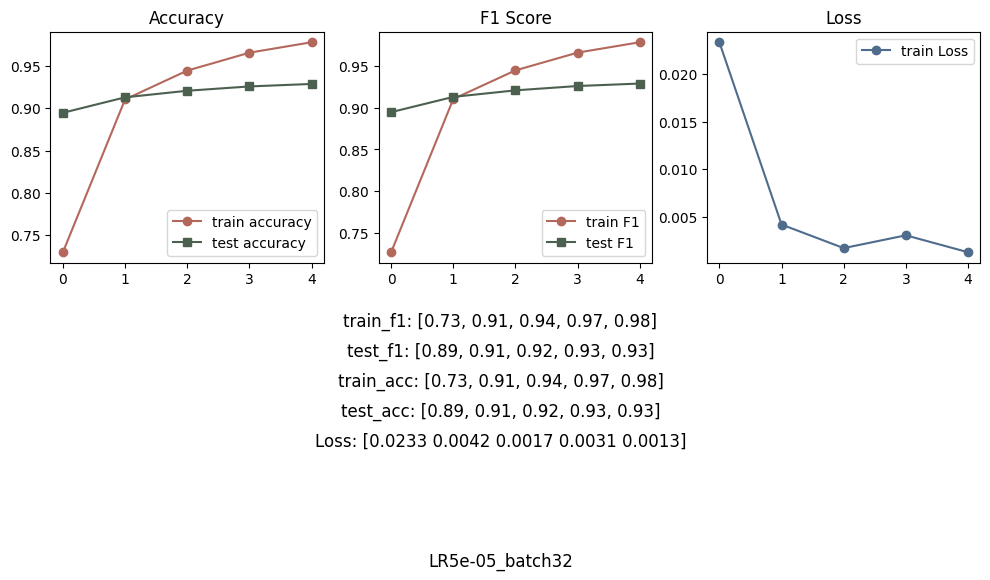

In [ ]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(history['train_acc'], color='#B3685C', marker='o', label='train accuracy')
plt.plot(history['test_acc'], color='#4C6050', marker='s', label='test accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_f1'], color='#B3685C', marker='o', label='train F1')
plt.plot(history['test_f1'], color='#4C6050', marker='s', label='test F1')
plt.title('F1 Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['train_loss'], color='#4F6C8C', marker='o', label='train Loss')
plt.title('Loss')
plt.legend()

# 지표 값 출력
train_f1_rounded = [round(value, 2) for value in history['train_f1']]
test_f1_rounded = [round(value, 2) for value in history['test_f1']]
train_acc_rounded = [round(value, 2) for value in history['train_acc']]
test_acc_rounded = [round(value, 2) for value in history['test_acc']]
train_loss_rounded = np.round(history['train_loss'], 4)  # NumPy 배열에 round 함수 적용

plt.figtext(0.5, -0.3, f"train_acc: {train_acc_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.1, f"train_f1: {train_f1_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.4, f"test_acc: {test_acc_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.2, f"test_f1: {test_f1_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.5, f"Loss: {train_loss_rounded}", ha='center', fontsize=12)
plt.figtext(0.5, -0.9, f"LR{learning_rate}_batch{batch_size}", ha='center', fontsize=12)

plt.show()

In [ ]:
torch.save(model,f'/content/drive/MyDrive/KOBERT/model/emotion/kobert_emotion_model_LR{learning_rate}_batch{batch_size}.pt')
torch.save

<function torch.serialization.save(obj: object, f: Union[str, os.PathLike, BinaryIO, IO[bytes]], pickle_module: Any = <module 'pickle' from '/usr/lib/python3.10/pickle.py'>, pickle_protocol: int = 2, _use_new_zipfile_serialization: bool = True) -> None>